In [1]:
using DelimitedFiles
using PyCall
using PyPlot
using Random
using Setfield
using Statistics
using ProgressMeter
using JLD2
using HDF5
using FileIO
using DataStructures
using CUDA
using DrWatson
using Measurements: value, uncertainty, ±

ENV["JULIA_REVISE_POLL"]=1
using Revise

using CMBLensing
using PtsrcLens

┌ Info: Precompiling PtsrcLens [44e3c0cc-451b-45a6-9d84-ed2affe90872]
└ @ Base loading.jl:1278


# Parallel setup

## ClusterManagers

In [ ]:
using Distributed, ClusterManagers
cluster_cookie("marius")
em = ElasticManager(addr=:auto, port=9312);

In [ ]:
em

## Local

In [2]:
using Distributed
addprocs(8);

## Init

In [3]:
@everywhere begin
    using Pkg
    Pkg.activate(".")
    using CUDA, CMBLensing, PtsrcLens
end

      From worker 3:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`


 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`


      From worker 6:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`
      From worker 4:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`
      From worker 7:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`
      From worker 2:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`
      From worker 5:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`
      From worker 8:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`
      From worker 9:	 Activating environment at `/global/u1/m/marius/work/ptsrclens/Project.toml`


In [4]:
CMBLensing.assign_GPU_workers();

┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142
┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142
┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142
┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142
┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142
┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142
┌ Warning: SLURM_STEP_GPUS not defined, assign_GPU_workers may fail.
└ @ Main /global/u1/m/marius/work/ptsrclens/dev/CMBLensing/src/gpu.jl:142

In [5]:
for i in workers()
    @fetchfrom i println(gethostname(),"::",device())
end

      From worker 2:	cgpu02::CuDevice(0)
      From worker 3:	cgpu02::CuDevice(5)
      From worker 4:	cgpu02::CuDevice(4)
      From worker 5:	cgpu02::CuDevice(1)
      From worker 6:	cgpu02::CuDevice(7)
      From worker 7:	cgpu02::CuDevice(3)
      From worker 8:	cgpu02::CuDevice(2)
      From worker 9:	cgpu02::CuDevice(6)


# Load files

In [20]:
@unpack (ϕs, κs, gs_ir, gs_radio, Ms_radio) = load_hdf5_cutouts();

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:02:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 

In [21]:
@save "data/sehgal_maps_h5/cutouts.jld2" ϕs κs gs_ir gs_radio Ms_radio;

## Load pre-processed

In [6]:
@load "data/sehgal_maps_h5/cutouts.jld2"

5-element Array{Symbol,1}:
 :ϕs
 :κs
 :gs_ir
 :gs_radio
 :Ms_radio

# Check power

In [7]:
@unpack (fg_noise_radio, fg_noise_ir) = get_foreground_noise(;Ms_radio, gs_radio, gs_ir);

In [8]:
tab = pyimport("pandas").DataFrame(Dict(
    148 => OrderedDict(fluxcut => value(fg_noise_radio[:deep,148,fluxcut]) for fluxcut in [Inf,10,5,2]),
    90  => OrderedDict(fluxcut => value(fg_noise_radio[:wide,90, fluxcut]) for fluxcut in [Inf,10,5,2]),
)).T
println(tab.to_latex(float_format="%.2f"))
tab

\begin{tabular}{lrrrr}
\toprule
{} &  inf  &  10.0 &  5.0  &  2.0  \\
\midrule
148 &  0.63 &  0.08 &  0.06 &  0.03 \\
90  &  1.46 &  0.19 &  0.13 &  0.08 \\
\bottomrule
\end{tabular}



,inf,10.0,5.0,2.0
148,0.632798,0.080185,0.057939,0.034663
90,1.464721,0.185232,0.131259,0.075241


In [9]:
fg_noise_ir

Dict{Tuple{Symbol,Int64,Float64},Float64} with 2 entries:
  (:deep, 148, Inf) => 0.0740397
  (:wide, 148, Inf) => 0.0740397

In [10]:
fg_noise_radio

OrderedDict{Tuple{Symbol,Int64,Real},Measurements.Measurement{Float64}} with 16 entries:
  (:deep, 90, 2)    => 0.074±0.039
  (:deep, 90, 5)    => 0.13±0.022
  (:deep, 90, 10)   => 0.184±0.016
  (:deep, 90, Inf)  => 1.4647±0.0034
  (:deep, 148, 2)   => 0.035±0.034
  (:deep, 148, 5)   => 0.058±0.02
  (:deep, 148, 10)  => 0.08±0.015
  (:deep, 148, Inf) => 0.6328±0.0023
  (:wide, 90, 2)    => 0.08±0.12
  (:wide, 90, 5)    => 0.131±0.071
  (:wide, 90, 10)   => 0.185±0.05
  (:wide, 90, Inf)  => 1.4647±0.0067
  (:wide, 148, 2)   => 0.036±0.052
  (:wide, 148, 5)   => 0.06±0.031
  (:wide, 148, 10)  => 0.082±0.023
  (:wide, 148, Inf) => 0.6328±0.003

# Reconstruct

In [11]:
ℓedges = [2:100:500; round.(Int, 10 .^ range(log10(502), log10(6000), length=10))];

In [12]:
noises = Dict(
    (:deep, 90)  => (μKarcminT=0.68/√2, beamFWHM=2.3, ℓknee=200, αknee=2),
    (:wide, 90)  => (μKarcminT=2.9/√2,  beamFWHM=2.2, ℓknee=700, αknee=1.4),
    (:deep, 148) => (μKarcminT=0.96/√2, beamFWHM=1.5, ℓknee=200, αknee=2),
    (:wide, 148) => (μKarcminT=2.8/√2,  beamFWHM=1.4, ℓknee=700, αknee=1.4),
);

In [13]:
ℓmax_datas = [5000]
polfrac_scales = [1]
freqs = [90, 148]
surveys = [:deep, :wide];

In [ ]:
PtsrcLens.main_MAP_grid(;surveys=[:wide],freqs=[90],ℓmax_datas=[5000],fluxcuts=[2],polfrac_scales=[1],Nbatch=16,overwrite=true,sims=1:40)

┌ Warning: Linesearch bracket converged to a point without satisfying Wolfe conditions?
└ @ OptimKit ~/.julia/packages/OptimKit/xpmbV/src/linesearches.jl:189
┌ Warning: Linesearch bracket converged to a point without satisfying Wolfe conditions?
└ @ OptimKit ~/.julia/packages/OptimKit/xpmbV/src/linesearches.jl:189
┌ Warning: Linesearch bracket converged to a point without satisfying Wolfe conditions?
└ @ OptimKit ~/.julia/packages/OptimKit/xpmbV/src/linesearches.jl:189
┌ Warning: Linesearch bracket converged to a point without satisfying Wolfe conditions?
└ @ OptimKit ~/.julia/packages/OptimKit/xpmbV/src/linesearches.jl:189
┌ Warning: Linesearch bracket converged to a point without satisfying Wolfe conditions?
└ @ OptimKit ~/.julia/packages/OptimKit/xpmbV/src/linesearches.jl:236
┌ Warning: Linesearch bracket converged to a point without satisfying Wolfe conditions?
└ @ OptimKit ~/.julia/packages/OptimKit/xpmbV/src/linesearches.jl:189
┌ Warning: Linesearch bracket converged to a point w

# Convergence

In [20]:
Cℓ = get_fiducial_Cℓ(ϕs);

In [85]:
ℓmax_data = 3000
polfrac_scale = 1
freq = 90
survey = :deep
fluxcut = 5;

In [86]:
noise_kwargs = noises[survey,freq]

(μKarcminT = 0.48083261120685233, beamFWHM = 2.3, ℓknee = 200, αknee = 2)

In [87]:
@unpack ds = load_sim_dataset(;
    Cℓ = Cℓ,
    θpix = 2,
    Nside = 300,
    pol = :P,
    bandpass_mask = LowPass(ℓmax_data),
    Nbatch = 1,
    noise_kwargs...
);

@unpack B = ds
ds.Cϕ = Cℓ_to_Cov(ϕs[1], (Cℓ.total.ϕϕ, ℓedges, :Aϕ));

μKarcmin_g = μKarcmin_gs_radio[survey,freq,fluxcut]

Cℓg = noiseCℓs(μKarcminT=polfrac_scale*μKarcmin_g/√2, beamFWHM=0, ℓknee=0)
Cg = Cℓ_to_Cov(Flat(Nside=300, θpix=2), Float32, S2, Cℓg.EE, Cℓg.BB);

let M = Ms_radio[survey,freq,fluxcut][1], g = gs_radio[freq][1]
    ds.Cn += polfrac_scale^2*B*Cg*B'
end;

In [88]:
fJ,ϕJ = MAP_joint(
    cu(ds),
    Nϕ       = :qe,
    nsteps   = 30,
    progress = true,
);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:08
  step:  30
  χ²:    179691.33
  Ncg:   2


In [89]:
let M = Ms_radio[survey,freq,fluxcut][1], g = gs_radio[freq][1]
    ds.d  += polfrac_scale*B*M*g
end;

In [90]:
fJ′,ϕJ′ = MAP_joint(
    cu(ds),
    Nϕ       = :qe,
    nsteps   = 30,
    progress = true,
);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:07
  step:  30
  χ²:    180840.44
  Ncg:   2


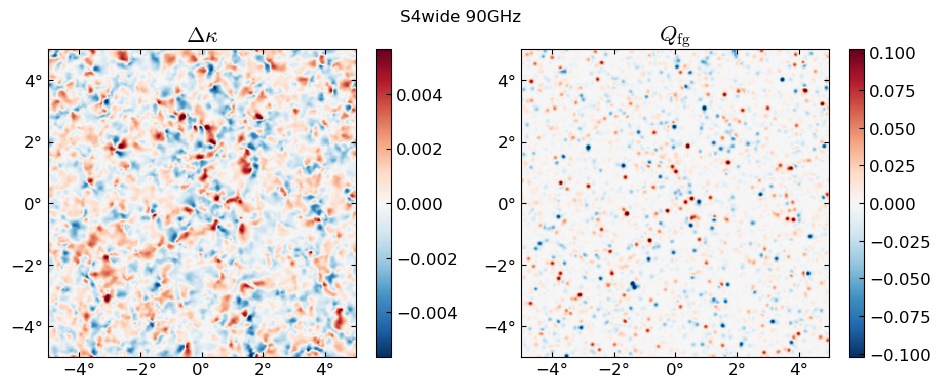

PyObject Text(0.5, 0.98, 'S4wide 90GHz')

In [84]:
plot(
    [∇²*(ϕJ′-ϕJ) (BandPassOp(beamCℓs(beamFWHM=5))*Ms_radio[survey,freq,fluxcut][1]*gs_radio[freq][1])[:Q]],
    title=[L"\Delta \kappa" L"Q_{\rm fg}"]
)
suptitle("S4wide 90GHz")

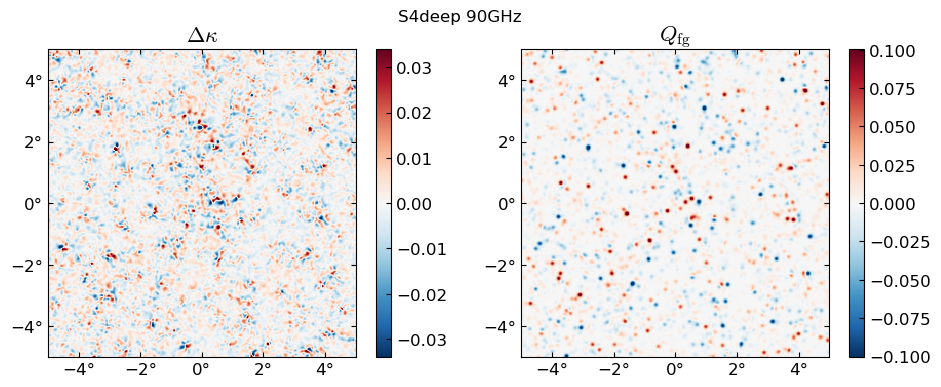

PyObject Text(0.5, 0.98, 'S4deep 90GHz')

In [91]:
plot(
    [∇²*(ϕJ′-ϕJ) (BandPassOp(beamCℓs(beamFWHM=5))*Ms_radio[survey,freq,fluxcut][1]*gs_radio[freq][1])[:Q]],
    title=[L"\Delta \kappa" L"Q_{\rm fg}"]
)
suptitle("S4deep 90GHz")